# Multivariate Linear Models

In [1]:
import  warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [3]:
sns.set()

## Spurious Association

### 5.1

In [4]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d["MedianAgeMarriage_s"] = (d["MedianAgeMarriage"] - d["MedianAgeMarriage"].mean())/d["MedianAgeMarriage"].std()

In [5]:
with pm.Model() as m5_1:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_1 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:15<00:00, 1417.75draws/s]


### 5.2

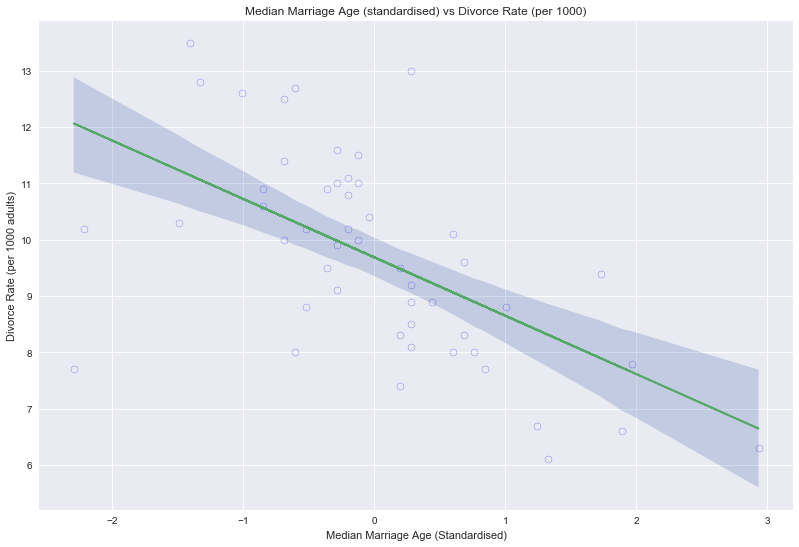

In [6]:
mu_mean = trace_5_1["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["MedianAgeMarriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["MedianAgeMarriage_s"], mu_mean.mean(0))

idx = np.argsort(d["MedianAgeMarriage_s"])
ax.fill_between(d["MedianAgeMarriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Median Marriage Age (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Median Marriage Age (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.3

In [7]:
d["Marriage_s"] = (d["Marriage"] - d["Marriage"].mean())/d["Marriage"].std()

In [8]:
with pm.Model() as m5_2:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["Marriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_2 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:13<00:00, 1616.39draws/s]


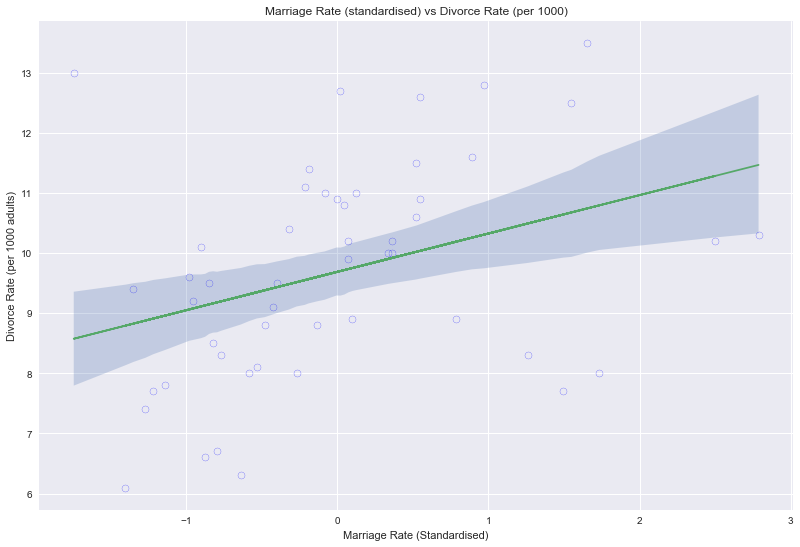

In [9]:
mu_mean = trace_5_2["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["Marriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["Marriage_s"], mu_mean.mean(0))

idx = np.argsort(d["Marriage_s"])
ax.fill_between(d["Marriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Marriage Rate (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Marriage Rate (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.4

In [10]:
with pm.Model() as m5_3:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)    
    bR = pm.Normal("bR", mu=0, sd=1)    
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bR * d["Marriage_s"]) + bA * d["MedianAgeMarriage_s"]
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_3 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:16<00:00, 1309.67draws/s]


In [11]:
pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.689826,0.214922,0.001671,9.347790,10.025859,17124.320179,1.000217
bR,-0.123372,0.296922,0.002286,-0.589854,0.354781,12889.847701,0.999982
bA,-1.122581,0.297699,0.002361,-1.599724,-0.651716,12189.321987,0.999977
sigma,1.524471,0.163636,0.001377,1.260917,1.767804,15157.620683,0.999953


### 5.5

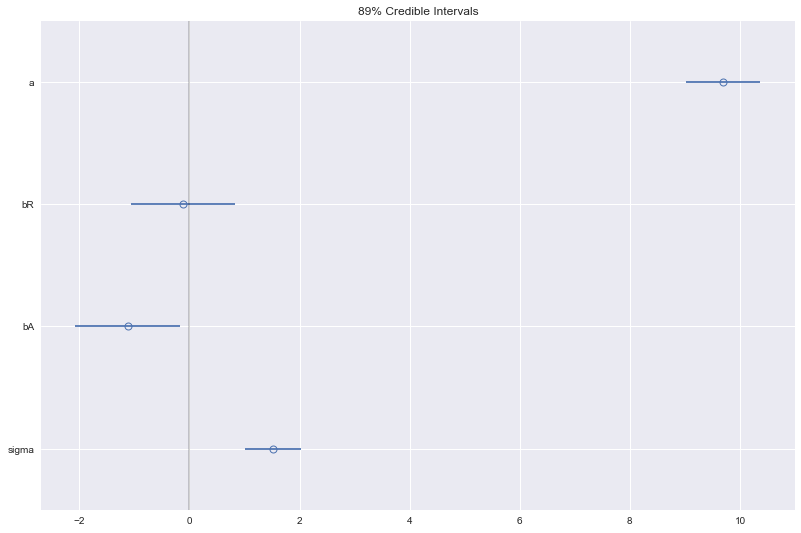

In [12]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.6

In [13]:
with pm.Model() as m5_4:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b = pm.Normal("b", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + b * d["MedianAgeMarriage_s"])
    Marriage_s = pm.Normal("Marriage_s", mu=mu, sd=sigma, observed=d["Marriage_s"])
    trace_5_4 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:13<00:00, 1606.19draws/s]


### 5.7

In [14]:
mu = trace_5_4["mu"].mean(0)
m_resid = d["Marriage_s"] - mu

### 5.8

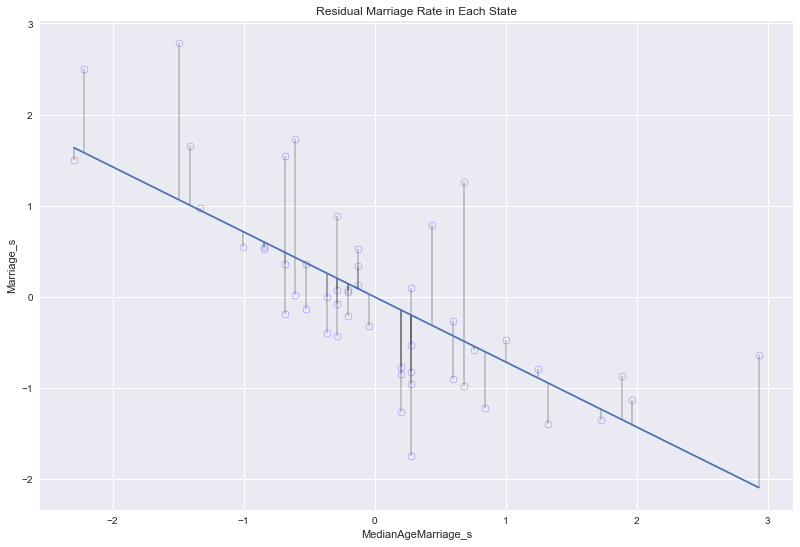

In [15]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
idx = np.argsort(d["MedianAgeMarriage_s"])
ax.plot(d["MedianAgeMarriage_s"][idx], mu[idx])
ax.vlines(d["MedianAgeMarriage_s"], mu, mu + m_resid, alpha=0.2)
ax.plot(d["MedianAgeMarriage_s"], mu + m_resid, "o", mew=0.2, mec="b", mfc="None")
ax.set_title("Residual Marriage Rate in Each State")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Marriage_s");

### 5.9

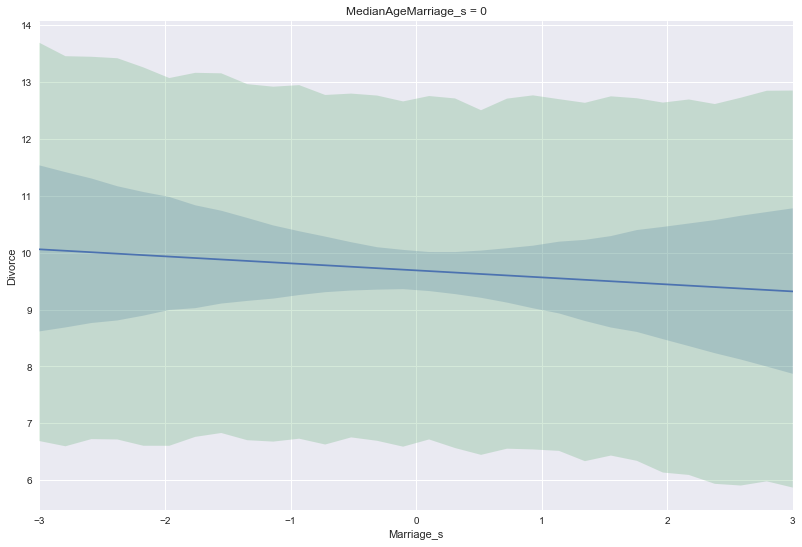

In [16]:
A_avg = d["MedianAgeMarriage_s"].mean()
R_seq = np.linspace(-3, 3, 30)

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"] * A_avg).reshape(-1, 1) +\
     (trace_5_3["bR"].reshape(-1, 1) * R_seq)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

R_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
R_pi = pm.hpd(R_sim)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(R_seq, mu_mean)
ax.fill_between(R_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(R_seq, R_pi[:,0], R_pi[:,1], alpha=0.25)
ax.set_title("MedianAgeMarriage_s = 0")
ax.set_xlabel("Marriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.10

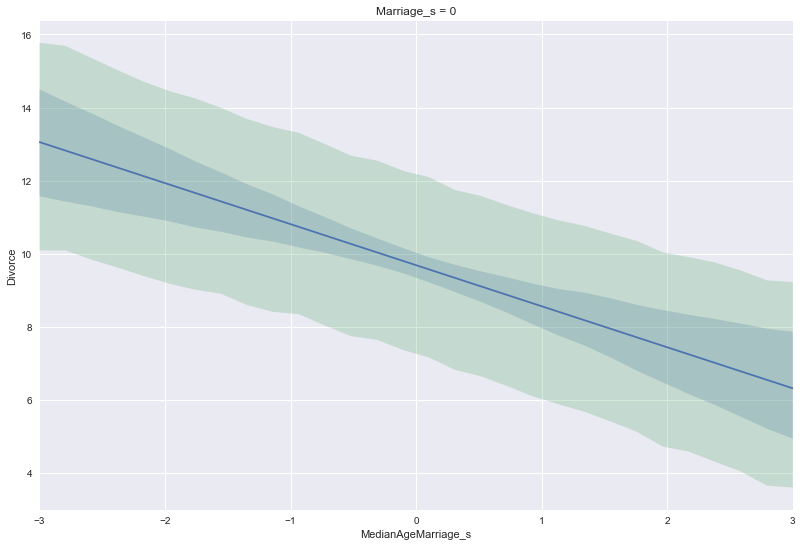

In [17]:
A_seq = np.linspace(-3, 3, 30)
R_avg = d["Marriage_s"].mean()

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"].reshape(-1, 1) * A_seq) +\
     (trace_5_3["bR"] * R_avg).reshape(-1, 1)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

A_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
A_pi = pm.hpd(A_sim, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(A_seq, mu_mean)
ax.fill_between(A_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(A_seq, A_pi[:,0], A_pi[:,1], alpha=0.25)
ax.set_title("Marriage_s = 0")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.11

In [18]:
mu = trace_5_3["mu"]

mu_mean = mu.mean(0).reshape(-1, 1)
mu_pi = pm.hpd(mu, alpha=.11)

divorce_sim = pm.sample_ppc(trace_5_3, samples=int(1e4), model=m5_3)['Divorce']
divorce_mean = divorce_sim.mean(0).reshape(-1, 1)
divorce_pi = pm.hpd(divorce_sim, alpha=.11)

100%|██████████| 10000/10000 [00:08<00:00, 1122.98it/s]


### 5.12 - 5.13

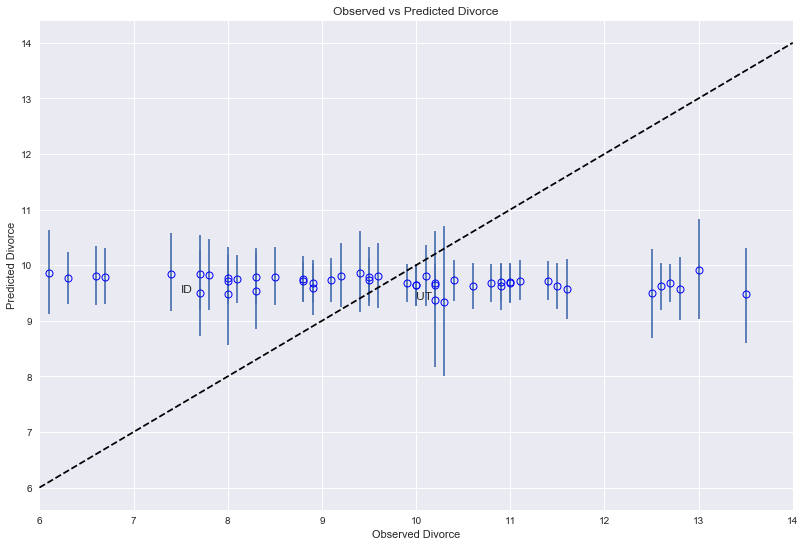

In [19]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=d["Divorce"], y=mu_mean, fmt="o", yerr=np.abs(mu_mean - mu_pi).T,
           mew=1.0, mec="b", mfc="None");
ax.plot([6, 14], [6, 14], "k--")
ax.set_title("Observed vs Predicted Divorce")
ax.set_xlabel("Observed Divorce")
ax.set_ylabel("Predicted Divorce")
ax.set_xlim(6, 14)

ID = (d.loc[12]["Divorce"], mu_mean[12])
UT = (d.loc[43]["Divorce"], mu_mean[43])
ax.annotate("ID", ID, xytext=(ID[0]-0.2, ID[1]))
ax.annotate("UT", UT, xytext=(UT[0]-0.2, UT[1]));

### 5.14

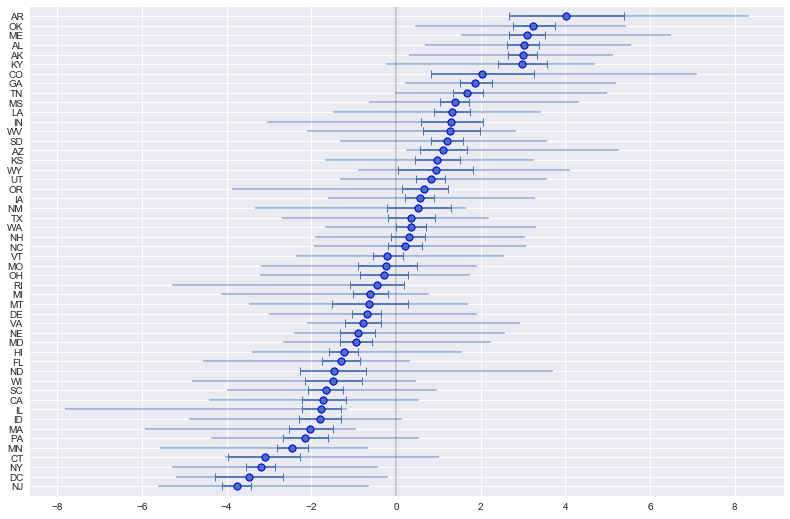

In [20]:
divorce_resid = d["Divorce"] - mu_mean.ravel()
o = np.argsort(divorce_resid)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.vlines(0, -1, len(d), alpha=0.2)
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-divorce_pi).T,
            fmt="o", mfc="C0", mew=1.0, mec="b", alpha=0.5, ecolor="C0")    
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-mu_pi).T, 
            fmt="o", capsize=4, mfc="C0", mew=1.0, mec="b", ecolor="C0")
ax.set_ylim(-1, len(d));

### 5.15

In [21]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(loc=x_real)
y = stats.norm.rvs(size=N, loc=x_real)
d = pd.DataFrame({"y": y,
                  "x_real": x_real,
                  "x_spur": x_spur})

## Masked Relationship

### 5.16

In [22]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.17

In [23]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * d["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_5 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains:   0%|          | 0/22000 [00:00<?, ?draws/s]


RuntimeError: Chain 0 failed.

### 5.18

In [24]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### 5.19

In [25]:
dcc = d.dropna()

### 5.20

In [26]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_5 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:19<00:00, 276.10draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 418 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5380482405496404, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


### 5.21

In [27]:
pm.summary(trace_5_5, varnames=["a", "bn", "sigma"], alpha=0.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.337,0.547,0.008,-0.506,1.208,3877.513,1.0
bn,0.005,0.008,0.000,-0.008,0.017,3878.992,1.0
sigma,0.192,0.039,0.001,0.135,0.249,1246.150,1.0


### 5.22

In [28]:
trace_5_5["bn"].mean() * (76 - 55)

0.09949838839001542

### 5.23

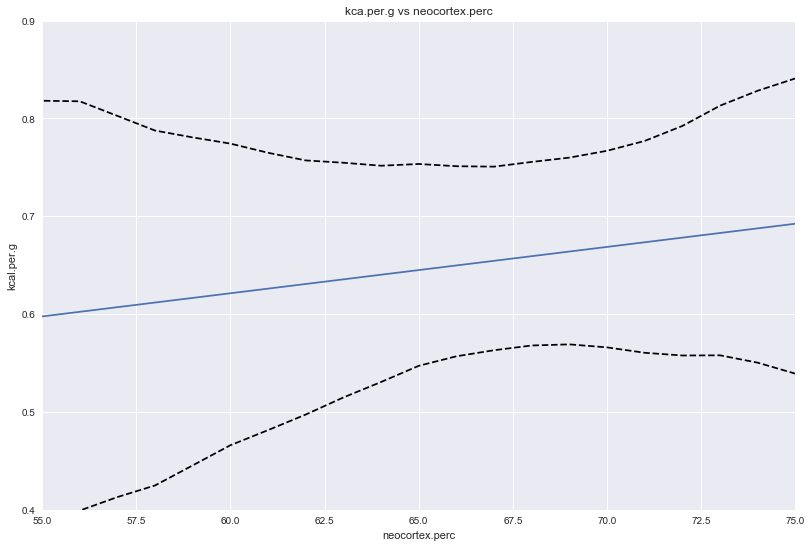

In [29]:
np_seq = np.arange(0, 100)

mu = trace_5_5["a"].reshape(-1, 1) +\
     (trace_5_5["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(0)
mu_pi = pm.hpd(mu)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc")
ax.set_ylim(0.4, 0.9);

### 5.24

In [30]:
dcc["log_mass"] = np.log(dcc["mass"])

### 5.25

In [31]:
with pm.Model() as m5_6:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm * dcc["log_mass"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_6 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_6, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:19<00:00, 1131.32draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.704318,0.058510,0.000530,0.610209,0.795245,10258.129799,0.999964
bm,-0.031252,0.024353,0.000227,-0.070992,0.006488,10098.736152,0.999950
sigma,0.183590,0.037920,0.000405,0.127207,0.237381,8980.262761,0.999953


### 5.26

In [32]:
with pm.Model() as m5_7:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm*dcc["log_mass"] + bn*dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_7 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_7, varnames=["a", "bm", "bn", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [02:00<00:00, 182.24draws/s]
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.080292,0.574094,0.008541,-1.973201,-0.156750,4313.021181,1.000106
bm,-0.095910,0.027629,0.000377,-0.140149,-0.052934,5232.886316,1.000021
bn,0.027840,0.008928,0.000134,0.014119,0.042385,4268.607140,1.000100
sigma,0.139278,0.029423,0.000685,0.094113,0.181092,2259.329864,1.000181


### 5.27

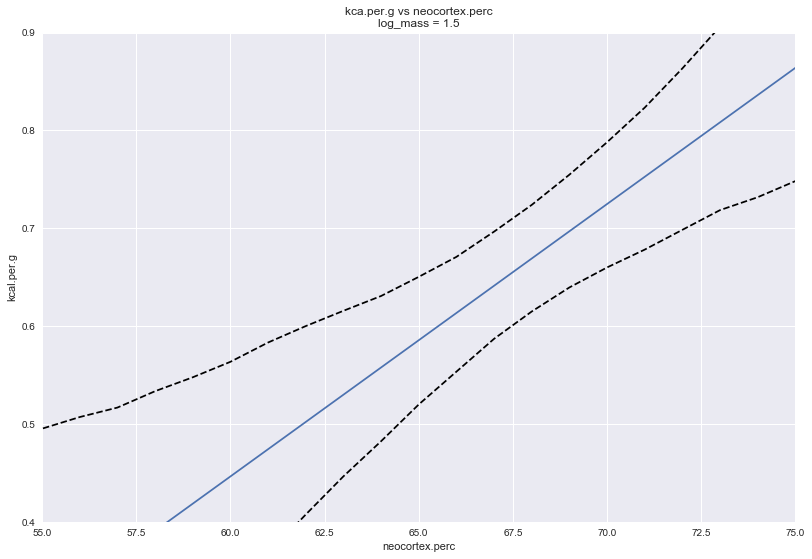

In [33]:
mean_log_mass = dcc["log_mass"].mean()
np_seq = np.arange(0, 100)

mu = trace_5_7["a"].reshape(-1, 1) +\
     (trace_5_7["bm"] * mean_log_mass).reshape(-1, 1) +\
     (trace_5_7["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc\nlog_mass = 1.5")
ax.set_ylim(0.4, 0.9);

### 5.28

In [34]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(loc=rho*x_pos, scale=np.sqrt(1-rho**2))
y = stats.norm.rvs(loc=x_pos-x_neg)
d = pd.DataFrame({"y": y,
                  "x_pos": x_pos,
                  "x_neg": x_neg})

## When adding variables hurts

### 5.29

In [35]:
N = 100
height = stats.norm.rvs(10, 2, N)
leg_prop = stats.uniform.rvs(0.4, 0.5, N)
leg_left = leg_prop*height + stats.norm.rvs(0, 0.02, N)
leg_right = leg_prop*height + stats.norm.rvs(0, 0.02, N)
d = pd.DataFrame({"height": height,
                  "leg_left": leg_left,
                  "leg_right": leg_right})

### 5.30

In [36]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    br = pm.Normal("br", mu=2, sd=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"] + br*d["leg_right"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_8 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, br, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [22:27<00:00,  9.30draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.442212,0.463543,0.004138,4.718573,6.187495,11929.617896,0.999988
bl,3.607864,4.113440,0.044029,-2.851480,10.236089,8345.881146,0.999969
br,-2.910897,4.105587,0.044000,-9.554744,3.513538,8358.374755,0.999970
sigma,1.370600,0.099038,0.000854,1.210166,1.524250,11835.606610,0.999953


### 5.31

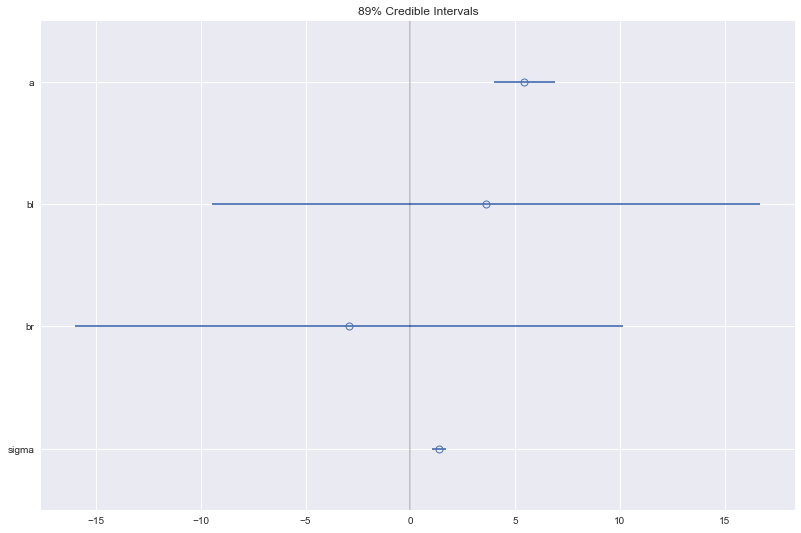

In [37]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.32

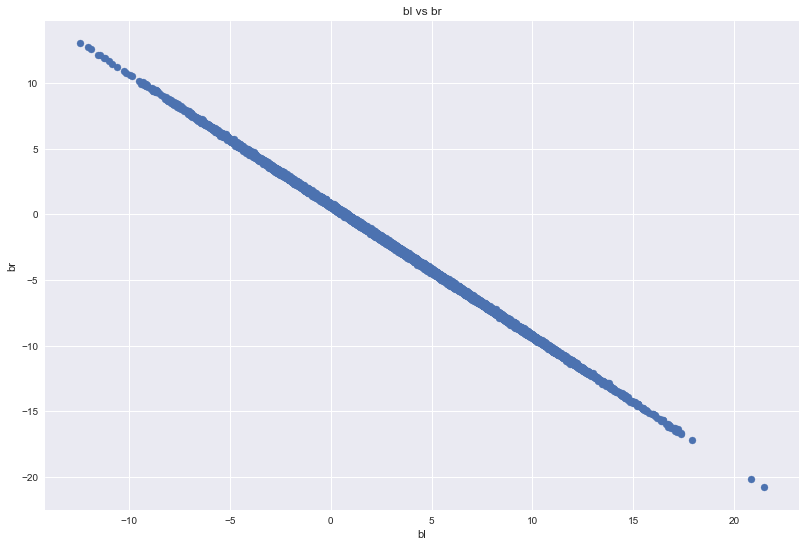

In [38]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.scatter(trace_5_8["bl"], trace_5_8["br"])
ax.set_xlabel("bl")
ax.set_ylabel("br")
ax.set_title("bl vs br");

### 5.33

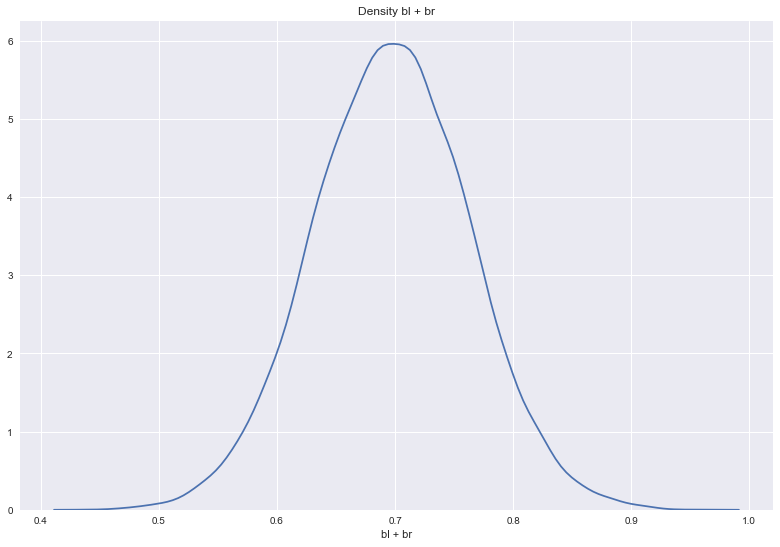

In [39]:
sum_blbr = trace_5_8["bl"] + trace_5_8["br"]

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(sum_blbr, ax=ax)
ax.set_title("Density bl + br")
ax.set_xlabel("bl + br");

### 5.34

In [40]:
with pm.Model() as m5_9:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_9 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_9, varnames=["a", "bl", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:23<00:00, 938.72draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.457270,0.457823,0.004233,4.728267,6.186688,9038.184095,0.999963
bl,0.692913,0.065133,0.000596,0.584588,0.791916,9001.502144,0.999954
sigma,1.370120,0.101048,0.001085,1.212105,1.530467,9152.591534,1.000012


### 5.35

In [41]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.36

In [42]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m5_10:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_10 = pm.sample(int(1e4), tune=1000)

# kcal.per.g regressed on perc.lactose
with pm.Model() as m5_11:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_11 = pm.sample(int(1e4), tune=1000)
    
print(pm.summary(trace_5_10, varnames=["a", "bf", "sigma"], alpha=0.11).round(3))
print(pm.summary(trace_5_11, varnames=["a", "bl", "sigma"], alpha=0.11).round(3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:23<00:00, 945.00draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [23:55<00:00, 15.32draws/s]  


        mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      0.301  0.039       0.0    0.237     0.361  7575.380   1.0
bf     0.010  0.001       0.0    0.008     0.012  7655.187   1.0
sigma  0.080  0.011       0.0    0.062     0.097  9233.497   1.0
        mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      1.165  0.046     0.001    1.091     1.238  7329.286   1.0
bl    -0.011  0.001     0.000   -0.012    -0.009  7348.399   1.0
sigma  0.067  0.010     0.000    0.052     0.081  8840.327   1.0


### 5.37

In [43]:
with pm.Model() as m5_12:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"] + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_12 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_12, varnames=["a", "bf", "bl", "sigma"], alpha=0.11).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, bl, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:48<00:00, 201.91draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.007,0.226,0.003,0.639,1.358,4958.069,1.0
bf,0.002,0.003,0.000,-0.002,0.006,5083.245,1.0
bl,-0.009,0.003,0.000,-0.013,-0.004,5018.243,1.0
sigma,0.068,0.010,0.000,0.052,0.082,6065.683,1.0


### 5.38

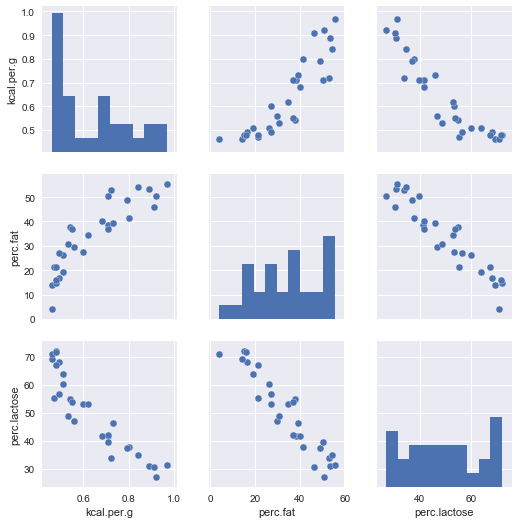

In [44]:
data = d[["kcal.per.g", "perc.fat", "perc.lactose"]]
sns.pairplot(data);

### 5.39

In [45]:
d.corr()["perc.fat"]["perc.lactose"]

-0.9416373456839282

### 5.40

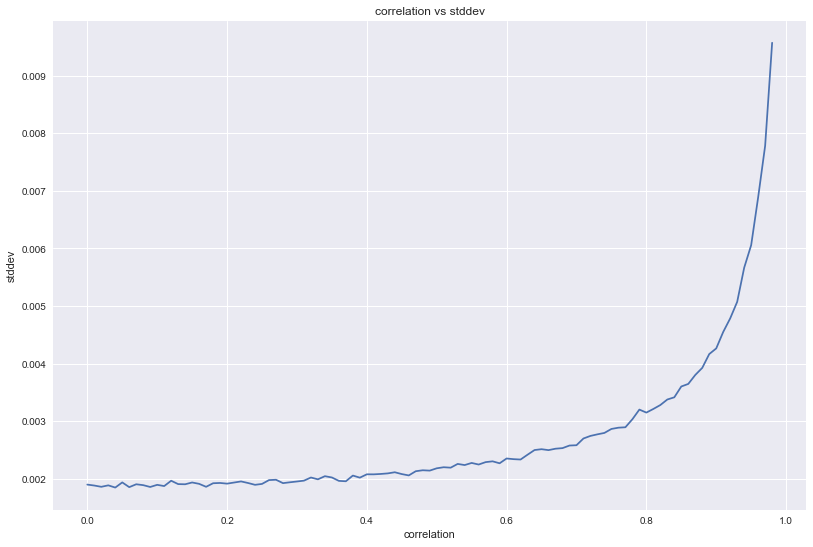

In [46]:
d = pd.read_csv('Data/milk.csv', sep=';')

def sim_coll(r=0.9):
    d['x'] = stats.norm.rvs(size=len(d), 
                            loc = r * d['perc.fat'],
                            scale = np.sqrt((1 - r**2) * d['perc.fat'].var()))
    m = smf.OLS(d['kcal.per.g'], d[["perc.fat", "x"]]).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def rep_sim_coll(r=0.9, n=100):
    stddev = [sim_coll(r) for _ in range(n)]
    return np.mean(stddev)

r_seq = np.arange(0, 0.99, 0.01)
stddev = [rep_sim_coll(r=z, n=100) for z in r_seq]


f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(r_seq, stddev)
ax.set_title("correlation vs stddev")
ax.set_xlabel("correlation")
ax.set_ylabel("stddev");

### 5.41

In [47]:
# Number of Plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(10, 2, N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = stats.binom.rvs(1, 0.5 - treatment*0.4)
h1 = h0 + stats.norm.rvs(5-3*fungus)

# compose a clean data frame
d = pd.DataFrame({"h0": h0,
                  "h1": h1,
                  "treatment": treatment,
                  "fungus": fungus})

### 5.42

In [48]:
with pm.Model() as m5_13:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"] + bf*d["fungus"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_13 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_13, varnames=["a", "bh", "bt", "bf", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, bf, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:02<00:00, 351.93draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,4.517734,0.569900,0.005590,3.618443,5.430401,8496.828777,0.999965
bh,1.058812,0.052251,0.000502,0.977239,1.142586,9231.216565,1.000013
bt,-0.072568,0.242922,0.002198,-0.453526,0.317101,11748.526021,0.999983
bf,-3.494134,0.295448,0.002205,-3.949182,-3.003126,13073.635552,1.000005
sigma,1.115369,0.081746,0.000688,0.983900,1.240967,15148.747801,1.000018


### 5.43

In [49]:
with pm.Model() as m5_14:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_14 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_14, varnames=["a", "bh", "bt", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:59<00:00, 368.22draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.144241,0.879546,0.009863,1.736765,4.544624,7454.676106,0.999978
bh,1.076996,0.081774,0.000876,0.949699,1.208819,7726.058770,1.000065
bt,0.917415,0.362893,0.003177,0.346825,1.494269,12508.357624,1.000059
sigma,1.748633,0.128501,0.001240,1.531800,1.938761,11974.195512,1.000191


## Categorical Variables

### 5.44

In [50]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### 5.45

In [51]:
with pm.Model() as m5_15:
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    bm = pm.Normal("bm", mu=0, sd=10)
    a = pm.Normal("a", mu=178, sd=100)
    mu = pm.Deterministic("mu", a + bm*d["male"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_15, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:31<00:00, 707.42draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,134.834803,1.596006,0.014112,132.197811,137.294121,12344.550685,1.000128
bm,7.270789,2.279559,0.020277,3.694218,10.954002,12023.647367,1.000430
sigma,27.412636,0.826128,0.005925,26.050433,28.686062,16533.822973,1.000042


### 5.46

In [52]:
mu_male = trace_5_15["a"] + trace_5_15["bm"]
pm.hpd(mu_male, alpha=0.11)

array([139.31550343, 144.67290168])

### 5.47

In [53]:
with pm.Model() as m5_15b:
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    am = pm.Normal("am", mu=178, sd=100)
    af = pm.Normal("af", mu=178, sd=100)
    mu = pm.Deterministic("mu", af*(1-d["male"]) + am*d["male"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15b = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [af, am, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:20<00:00, 1057.10draws/s]


### 5.48

In [54]:
d = pd.read_csv('Data/milk.csv', sep=';')
d["clade"].drop_duplicates()

0        Strepsirrhine
5     New World Monkey
14    Old World Monkey
20                 Ape
Name: clade, dtype: object

### 5.49

In [55]:
d["clade_NWM"] = np.where(d["clade"] == "New World Monkey", 1, 0)

### 5.50

In [56]:
d["clade_OWM"] = np.where(d["clade"] == "Old World Monkey", 1, 0)
d["clade_S"] = np.where(d["clade"] == "Strepsirrhine", 1, 0)

### 5.51

In [57]:
with pm.Model() as m5_16:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b_S = pm.Normal("b_S", mu=0, sd=1)
    b_OWM = pm.Normal("b_OWM", mu=0, sd=1)
    b_NWM = pm.Normal("b_NWM", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + b_NWM*d["clade_NWM"] + b_OWM*d["clade_OWM"] + b_S*d["clade_S"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_16 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_16, varnames=["a", "b_NWM", "b_OWM", "b_S", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b_NWM, b_OWM, b_S, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:27<00:00, 803.82draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.545978,0.043233,0.000446,0.477336,0.613648,9307.881476,0.999958
b_NWM,0.168298,0.061649,0.000598,0.071151,0.264911,11359.416859,0.999958
b_OWM,0.241724,0.067939,0.000582,0.135910,0.349752,10791.286119,0.999952
b_S,-0.037916,0.071900,0.000619,-0.156026,0.071548,12242.397515,0.999972
sigma,0.129733,0.019750,0.000157,0.098600,0.158444,12811.907509,0.999956


### 5.52

In [58]:
mu_ape = trace_5_16["a"]
mu_NWM = trace_5_16["a"] + trace_5_16["b_NWM"]
mu_OWM = trace_5_16["a"] + trace_5_16["b_OWM"]
mu_S = trace_5_16["a"] + trace_5_16["b_S"]

mu = np.stack([mu_ape, mu_NWM, mu_OWM, mu_S]).T
mu_mean = np.mean(mu, axis=0)
mu_std = np.std(mu, axis=0)
mu_hpd = pm.hpd(mu, alpha=0.11)

pd.DataFrame({"mean": mu_mean,
              "std": mu_std,
              "hpd_5.5": mu_hpd[:, 0],
              "hpd_94.5": mu_hpd[:, 1]},
             index=["mu_ape", "mu_NWM", "mu_OWM", "mu_S"])

,mean,std,hpd_5.5,hpd_94.5
mu_ape,0.545978,0.043233,0.477336,0.613648
mu_NWM,0.714277,0.043925,0.642596,0.781339
mu_OWM,0.787703,0.052660,0.706789,0.873875
mu_S,0.508063,0.057591,0.413389,0.597157


### 5.53

In [59]:
diff_NWM_OWM = mu_NWM - mu_OWM
np.percentile(diff_NWM_OWM, [2.5, 50, 97.5])

array([-0.20941412, -0.0733889 ,  0.06171132])

### 5.54

In [60]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

### 5.55

In [61]:
with pm.Model() as m5_16_alt:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    a = pm.Normal("a", mu=0.6, sd=10, shape=len(d["clade_id"].unique()))
    kcal_per_g = pm.Normal("kcal_per_g", mu=a[d["clade_id"].values], sd=sigma, observed=d["kcal.per.g"])
    trace_5_16_alt = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_16_alt, varnames=["a", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:21<00:00, 1008.51draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,0.545316,0.043631,0.000289,0.475090,0.613480,23563.265433,0.999968
a__1,0.714377,0.044037,0.000312,0.643069,0.782725,22683.283394,0.999951
a__2,0.788475,0.053387,0.000361,0.706473,0.875743,25503.188332,1.000003
a__3,0.508556,0.058407,0.000437,0.417016,0.602301,18849.038273,1.000216
sigma,0.129890,0.019575,0.000141,0.099028,0.158447,17025.804583,1.000273


### Ordinary Least Squares and `lm`

Code blocks *5.56 - 6.61* are specific to R's `lm` function and aren't that useful in this exercise

### 5.62

In [62]:
cars = pd.read_csv('Data/cars.csv', index_col=0)
pm.GLM.from_formula("dist ~ speed", data=cars)